In [1]:
import numpy as np
from grid import Grid
from actors import QLearning
from plot import plotPolicy

g = Grid()
q = QLearning(g)

for episodes in range(2000):
    q.resetCount()
    q.run(epsilon=.1)

# Geradores

## Política

<AxesSubplot: >

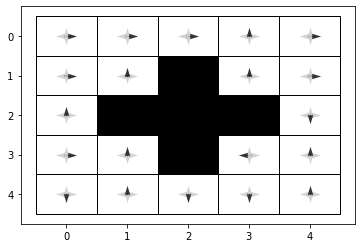

In [2]:
def generatePi(q, g, e=.1):
    # if not(0 < e < 1):
    #     return -np.inf
    p_a = lambda a, s: (e/4, 1-e+e/4)[a == max(q[s], key=q[s].get)] if 0 < e < 1 else 1e-10
    pi = np.array([[p_a(a, s) for a in g.ACTIONS] for s in g.S])
    return pi.reshape(g.size[0], g.size[1], len(g.ACTIONS), order='F')

pi_star = generatePi(q.Q, g, .3)

from plot import plotPolicy
plotPolicy(pi_star, g)

## Trajetória

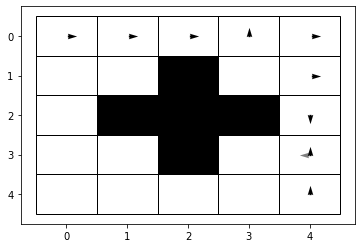

In [3]:
import random
def generateTrajetory(pi, g,  kind=0, size=10):
    s = (0,0)

    arr = []
    for t in range(size):
        a  = random.choices(g.ACTIONS, pi[s], k=1)[0]
        if kind in ['values', 0]:
            step =  (s, a)
        elif kind in ['indexes', 1]:
            step =  (g.S.index(s), g.ACTIONS.index(a))
        elif kind in ['states values', 2]:
            step =  (s, g.ACTIONS.index(a))
        elif kind in ['action values', 3]:
            step =  (g.S.index(s), a)

        s,_,_ = g.transition(s,  a)

        arr.append(step)

    return arr

from plot import plotTrajectory
plotTrajectory(generateTrajetory(pi_star, g), g)

trajectory_pi_star = generateTrajetory(pi_star, g, 2)

# Q-Learning

### Politica 1 - (up,right)

In [4]:
g_1 = Grid()
target_1 = (4,0)
g_1.effects[(4,4)] = {'noise': lambda a: [-a[0], -a[1]]}
g_1.effects[target_1] = {'terminal': True, 'reward': 10}


Episodes: 1999
Steps: 136
Rewards: -34


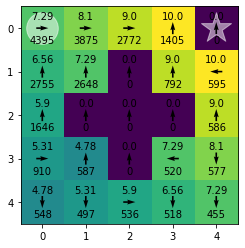

In [5]:
from actors import QLearning

q_1 = QLearning(g_1)

for episodes in range(2000):
    q_1.resetCount()
    q_1.run(epsilon=.9)

print('Episodes:', episodes)
print('Steps:', q_1.steps)
print('Rewards:', q_1.totalReward)

q_1.plot()

<AxesSubplot: >

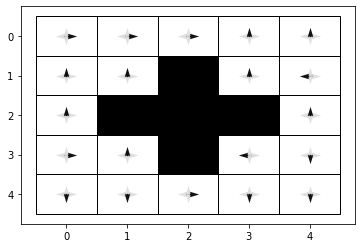

In [6]:
pi_1 = generatePi(q_1.Q, g_1, .1)
plotPolicy(pi_1, g_1)

### Politica 2 - (down,left)

In [7]:
g_2 = Grid()

target_2 = (0,4)
g_2.effects[(4,4)] = {'noise': lambda a: [-a[0], -a[1]]}
g_2.effects[target_2] = {'terminal': True, 'reward': 10}


Episodes: 1999
Steps: 26
Rewards: -2


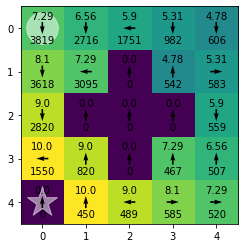

In [8]:
from actors import QLearning

q_2 = QLearning(g_2)

for episodes in range(2000):
    q_2.resetCount()
    q_2.run(epsilon=.9)

print('Episodes:', episodes)
print('Steps:', q_2.steps)
print('Rewards:', q_2.totalReward)

q_2.plot()

<AxesSubplot: >

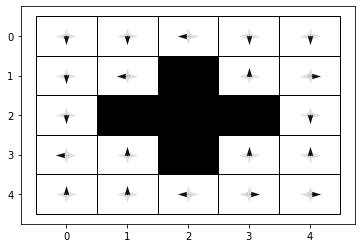

In [9]:
pi_2 = generatePi(q_2.Q, g_2, .1)
plotPolicy(pi_2, g_2)

# Estimadores

## Likelihood

### Glossário
$\xi$ : Trajetória (sequencia de estados e ações) <br>
$\mathcal{H}$ : Conjunto de Options <br>
$\psi_h(s) \in [0,1]$ : Politica de termino (Probabilidade de Término da option $h$ no estado $s$) <br>
$\eta(h|s) $ : Politica Superior (Probabilidade de estar na option $h$ dado o estado $s$)<br>

$\xi = x_1^{10} $ com $ x_i = (s,a) $ para $ s_0 = 0, s_i = p(s_i|s_{i-1}, a_{i-1}) $ e $ a_i = \pi^*(s_i)$ <br>
$\psi_h(s) = \{_{0, s \ne s^{t_h}}^{1, s = s^{t_h} } $ para $ s^{t_h}=$ Estado $s$ objetivo para $\pi_h$ <br>
$\mathcal{H} = h_1^2 $ com $ h_i = (\pi_i, \psi_i)$ <br>
$\eta(h|s) = \frac{\sum_{a} q_h(a, s)}{\sum_{h}\sum_{a} q_h(a, s)}$

In [10]:
pH = [
    lambda s: 0 if sum(q_1.Q[s].values()) + sum(q_2.Q[s].values()) == 0 else sum(q_1.Q[s].values()) / (sum(q_1.Q[s].values()) + sum(q_2.Q[s].values())),
    lambda s: 0 if sum(q_1.Q[s].values()) + sum(q_2.Q[s].values()) == 0 else sum(q_2.Q[s].values()) / (sum(q_1.Q[s].values()) + sum(q_2.Q[s].values())),
]

In [11]:
E = generateTrajetory(pi_star, g, kind=1)
psi_1 = [int(s==target_1) for s in g.S]
psi_2 = [int(s==target_2) for s in g.S]
H = [
    (pi_1, psi_1),
    (pi_2, psi_2)
]
eta = np.array([[pH[h](s) for h,_ in enumerate(H)] for s in g.S])

### Trajectory Prefix

$\phi_0(h) = p_0(s_0)\eta(h|s_0)$
<br>
$\phi_{t+1}(h') = \sum_{h \in \mathcal{H}} \lgroup \phi_t(h)\pi_h(a_t|s_t) p(s_{t+1}|s_t, a_t) \psi_h(s_{t+1}) \rgroup \;\; \eta(h'|s_{t+1}) + \phi_t(h') \pi_{h'}(a_t|s_t) p(s_{t+1} | s_t, a_t) (1-\psi_{h'}(s_{t+1})) $

#### Algoritmo de Programação Dinâmica:
```algorithm
calcula_Phi (t, h)
    se não existe t em phi[h]
        se não existe t-1 em phi[h]
            para cada h_ em H
                phi[h_, t-1] <-  calcula_Phi(h_, t-1)
        phi[h, t] <- PHIt+1(h)  
    devolva phi[h, t]
```

In [12]:
def __phi(t,h, E,H):
    s,a = E[t]
    if t==0:
        return eta[s, h]
    
    s_,_ = E[t+1]
    pi, psi = H[h]

    term_1 = sum(phi_table[h_][t-1] * pi_[g.S[s]][a] * psi_[s_] for h_,(pi_, psi_) in enumerate(H)) * eta[s_, h]
    term_2 = phi_table[h][t-1] * pi[g.S[s]][a] * (1-psi[s_])

    return term_1 + term_2 


phi_table = [{0: __phi(0,h, E,H)} for h,_ in enumerate(H)]

def prefix_likelihood(h,t, E,H):
    if t not in phi_table[h]:
        if t-1 not in phi_table[h]:
            for h_, _ in enumerate(H):
                phi_table[h_][t-1] = prefix_likelihood(h_,t-1, E,H)
        phi_table[h][t] = __phi(t,h, E,H)
    return phi_table[h][t]

### Trajectory Suffix

$\omega_{T-1}(h) = \pi_h(a_{T-1}|s_{T-1}) p(s_T | s_{T-1}, a_{T-1}) $
<br>
$\omega_t(h) = \pi_h(a_t|s_t) p(s_{t+1} | s_t, a_t) \lgroup \psi_h(s_{t+1}) \sum_{h' \in \mathcal{H}} \eta(h'|s_{t+1})\omega_{t+1}(h') + (1- \psi_h(s_{t+1})) \omega_{t+1}(h) \rgroup $

#### Algoritmo de Programação Dinâmica: 
```algorithm
calcula_W (t, h)
    se não existe t em w[h]
        se não existe t+1 em w[h]
            para cada h_ em H
                w[h_, t+1] <-  calcula_W(h_, t+1)
        w[h, t] <- Wt(h)  
    devolva w[h, t]
```

In [13]:
def __omega(t,h, E,H):
    _s,_a = E[-1]
    pi, psi = H[h]
    
    if t==(len(E)-1):
        return pi[g.S[_s]][_a]
    
    s,a = E[t]
    s_,_ = E[t+1]
    
    term_1 = psi[s_] * sum(eta[s_, h_] * w_table[h_][t+1] for h_,_ in enumerate(H))
    term_2 = (1- psi[s_]) * w_table[h][t+1]

    return pi[g.S[s]][a] * (term_1 +  term_2)

w_table = [{(len(E)-1): __omega((len(E)-1),h, E,H)} for h,_ in enumerate(H)]

def suffix_likelihood(h, t, E, H):
    if t not in w_table[h]:
        if t+1 not in w_table[h]:
            for h_, _ in enumerate(H):
                w_table[h_][t+1] = suffix_likelihood(h_,t+1, E,H)
        w_table[h][t] = __omega(t,h, E,H)
    return w_table[h][t]

### Target
$\mathbb{P}_{\theta}(\xi) = \sum_{h \in \mathcal{H}} \phi_t(h)\omega_t(h)$ 

In [14]:
def likelihood(t, E,H):
    phi = prefix_likelihood
    omega = suffix_likelihood

    v = [phi(h,t, E,H) * omega(h,t, E,H) for h,_ in enumerate(H)]
    return sum(v)

likelihood(0, E, H)

4.526707066822055e-06

In [15]:
likelihood(4, E, H)

1.2234578428268442e-07

### Marginal Posteriors


$ u_{t}(h) = \frac{1}{\mathbb{P}(\xi)} \phi_t(h)\omega_t(h)$

In [17]:
def u(h, t, E, H):
    phi = prefix_likelihood
    omega = suffix_likelihood

    return 1/likelihood(t, E, H) * phi(h,t, E,H) * omega(h,t, E,H)
    

$ v_{0}(h) = u_0(h) $
<br><br>
$ v_{t+1}(h') = \frac{1}{\mathbb{P}(\xi)} \; \lgroup \; \sum_{h \in \mathcal{H}} \phi_t(h) \pi_h(a_t|s_t) p(s_{t+1}|s_t, a_t) \psi_h(s_{t+1}) \; \rgroup \; \eta(h'|s_{t+1}) \omega_{t+1}(h') $

In [18]:
def v(h, t, E, H):
    if t == 0:
        return u(h, t, E, H)

    s,a = E[t]
    s_,_ = E[t+1]

    phi = prefix_likelihood
    omega = suffix_likelihood

    somatoria = np.sum(phi(h,t, E,H) * pi[g.S[s]][a] * psi[s_] for h,(pi, psi) in enumerate(H))

    return 1/likelihood(t, E, H) * somatoria * eta[s_, h] * omega(h,t+1, E,H)

$ w_t(h) = \frac{1}{\mathbb{P}(\xi)} \phi_t(h) \pi_h(a_t|s_t) p(s_{t+1} | s_t, a_t) (1-\psi_h(s_{t+1})) \omega_{t+1}(h) $

In [19]:
def w(h, t, E, H):
    phi = prefix_likelihood
    omega = suffix_likelihood

    s,a = E[t]
    s_,_ = E[t+1]
    pi, psi = H[h]

    return 1/likelihood(t, E, H) * phi(h,t, E,H) * pi[g.S[s]][a] * (1-psi[s_]) * omega(h,t+1, E,H)

### Final Likelihood

$ \nabla_{\theta}L[\theta;\xi] = \sum_{h \in \mathcal{H}} \; \lgroup \; \sum_{t=0}^{T-1} \;\lgroup\; v_t(h) \nabla_{\theta} log \eta(h|s_t) + u_t(h) \nabla_{\theta} log \pi_h(a_t|s_t)
\;\rgroup\; + \sum_{t=0}^{T-2} \;\lgroup\; (u_t(h) - w_t(h)) \nabla_{\theta} log \psi_h(s_{t+1}) + w_t(h) \nabla_{\theta} log (1-\psi_h(s_{t+1})) \;\rgroup\;\;\rgroup\; $ 

Sendo:<br><br>
$ \nabla_{\theta} log \eta(h|s_t) = \frac{\partial log \eta(h|s_t)}{\partial \theta} = \frac{1}{\eta(h|s_t)} \frac{\partial \eta(h|s_t)}{\partial \theta} =        $ <br><br>
$ \nabla_{\theta} log \pi_h(a_t|s_t) = \frac{\partial log \pi_h(a_t|s_t)}{\partial \theta} = \frac{1}{\pi_h(a_t|s_t)} \frac{\partial \pi_h(a_t|s_t)}{\partial \theta} =    $ <br><br>
$ \nabla_{\theta} log \psi_h(s_{t+1}) = \frac{\partial log \psi_h(s_{t+1})}{\partial \theta} = \frac{1}{\psi_h(s_{t+1})} \frac{\partial \psi_h(s_{t+1})}{\partial \theta} =      $ <br><br>
$ \nabla_{\theta} log (1-\psi_h(s_{t+1})) = \frac{\partial log (1-\psi_h(s_{t+1}))}{\partial \theta} = \frac{1}{1-\psi_h(s_{t+1})} (-\frac{\partial \psi_h(s_{t+1})}{\partial \theta}) =    $

In [32]:
def expectation_gradient(E, H):
    term1 = lambda t,s,a,h,pi:  v(h, t, E, H) * 1/eta[s, h] + u(h, t, E, H) * 1/pi[g.S[s]][a]
    term2 = lambda t,h,psi:  (u(h, t, E, H) - w(h, t, E, H)) * 1/psi[E[t+1][0]] + w(h, t, E, H) * 1/(1 - psi[E[t+1][0]])

    sum_1 = lambda h, pi: np.sum(term1(t,s,a,h,pi) for t,(s,a) in enumerate(E) if t < (len(E)-1))
    sum_2 = lambda h, psi: np.sum(term2(t,h,psi) for t,_ in enumerate(E) if t < (len(E)-1))

    return np.sum(sum_1(h, pi) + sum_2(h, psi) for h,(pi, psi) in enumerate(H))

expectation_gradient(E, H)

C:\Users\guilherme.albarrans\AppData\Local\Temp\ipykernel_29400\3245321987.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(sum_1(h, pi) + sum_2(h, psi) for h,(pi, psi) in enumerate(H))
C:\Users\guilherme.albarrans\AppData\Local\Temp\ipykernel_29400\2620467756.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  somatoria = np.sum(phi(h,t, E,H) * pi[g.S[s]][a] * psi[s_] for h,(pi, psi) in enumerate(H))
C:\Users\guilherme.albarrans\AppData\Local\Temp\ipykernel_29400\3245321987.py:2: RuntimeWarning: invalid value encountered in double_scalars
  term1 = lambda t,s,a,h,pi:  v(h, t, E, H) * 1/eta[s, h] + u(h, t, E, H) * 1/pi[g.S[s]][a]
C:\Users\guilherme.albarrans\AppData\Local\Temp\ipykernel_29400\3245321987

nan